In [1]:
# Example using sunkit-spex with my generated spectra/srm for the RHESSI weeflares
# 
# Here testing with the microflare from 17-Nov-2006 about 05:13
# from wee_flares/fits/2006/11/
# 
# For more example detail see (though not totally correct/working?)
# https://github.com/sunpy/sunkit-spex/blob/main/examples/fitting_RHESSI_spectra.py
# 
# 23-Jan-2025 IGH
# 30-Jan-2025 Checked with v0.4.1.dev22
# 06-Feb-2025 Testing some addtional things...

In [2]:
from astropy.time import Time, TimeDelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sunpy.io.special import read_genx
# Note this load in is a WIP during the refactor/rename
# works with v0.4.1.dev21
from sunkit_spex.extern.rhessi import RhessiLoader
from sunkit_spex.legacy.fitting.fitter import Fitter

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

plt.rcParams.update({'font.size': 18,'mathtext.default':"regular"})

In [3]:
#  Some useful functions for dealing with converting the flare times to strings for filenames
# based off break_time.pro in sswidl, where
# Return a string with a trailing 0 if <10
def ldz_int(num):
    if num<10:
        return f'0{int(num):d}'
    if num >=10:
        return f'{int(num):d}'
# Convert astropy time into break_time sswidl format used for the filenames
def break_time(time):
    t=time.ymdhms
    stime=f'{t.year:d}'+ldz_int(t.month)+ldz_int(t.day)+'_'+\
        ldz_int(t.hour)+ldz_int(t.minute)+ldz_int(t.second)
    return stime

In [4]:
# Use the genx file info for the times and the filename
res=read_genx('../wee_2008/wee_all_v2.genx')

In [5]:
# Find the hard event again 6111704 17-Nov-2006 05:13:38
hid=(np.where(res["SAVEGEN0"]["FPEAK"] == "2006-11-17T05:13:38.000"))[0][0]
print(hid)

# Then save some useful info from the weeflare list in
ftims=Time(res["SAVEGEN0"]["FPEAK_TR"][hid],format='isot')
btims=Time(res["SAVEGEN0"]["BK_BF_TR"][hid],format='isot')
tt=Time(res["SAVEGEN0"]["FPEAK"][hid],format='isot')
fname=break_time(tt)
print(fname)

print(ftims)
print(btims)

24109
20061117_051338
['2006-11-17T05:13:30.000' '2006-11-17T05:13:46.000']
['2006-11-17T05:11:50.000' '2006-11-17T05:12:06.000']


In [6]:
# Some setup for sunxspex
time_profile_size = (9,6)
spec_single_plot_size = (6,8)
spec_plot_size = (16,10)
spec_font_size = 18
default_font_size = 10
xlims, ylims = [3,30], [5e-2,3e4]
tol = 1e-5

# Where are the spec and srm fits files ???
# On server
# _dir = "wee_flares/fits/"+fname[:4]+"/"+fname[4:6]+"/"
# just locally for testing
# _dir = "/Users/iain/github/sks_examples/fits/"
_dir = "fits/"

print(_dir)
print(_dir+fname+"_spec_sum.fits")
print(_dir+fname+"_srm_sum.fits")

fits/
fits/20061117_051338_spec_sum.fits
fits/20061117_051338_srm_sum.fits


In [7]:
rhess_spec = RhessiLoader(spectrum_fn=_dir+fname+"_spec_sum.fits", srm_fn=_dir+fname+"_srm_sum.fits")

In [8]:
# Whats the max energy bin of this srm/spec file
maxe=rhess_spec._loaded_spec_data["count_channel_bins"][-1]
print(maxe)

[35.666668 36.      ]


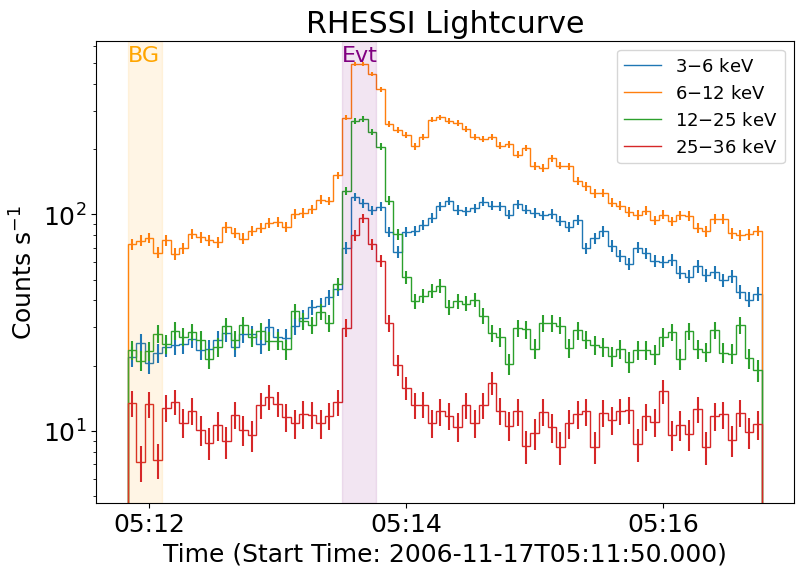

In [9]:
plt.rcParams['font.size'] = spec_font_size
plt.figure(figsize=time_profile_size)
rhess_spec.update_background_times(btims[0],btims[1])
rhess_spec.update_event_times(ftims[0],ftims[1])
rhess_spec.lightcurve(energy_ranges=[[3,6], [6,12], [12,25],[25,maxe[1].astype(int)]])
plt.show()
plt.rcParams['font.size'] = default_font_size

In [10]:
fitter = Fitter(rhess_spec)

fitter.model = "(f_vth+thick_fn)"
fitter.loglikelihood = "cstat"
fitter.show_params

Param,Status,Value,Bounds,Error
,,,"(min, max)","(-, +)"
str22,str11,float64,object,object
T1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
EM1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
total_eflux1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
index1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
e_c1_spectrum1,free,1.00e+00,"(0.0, None)","( 0.00e+00, 0.00e+00)"
Fit Stat.,cstat ln(L),0.00e+00,--,--


In [11]:
# Fit setup and ranges optimised for this data (3-36 keV) and harder microflares
fitter.energy_fitting_range = [4,10]
fitter.params["T1_spectrum1"] = {"Value":10, "Bounds":(7, 20)}
fitter.params["EM1_spectrum1"] = {"Value":1, "Bounds":(1e-2, 1e2)}
fitter.params["total_eflux1_spectrum1"] = {"Status":"fix", "Value":0.9, "Bounds":(1e-2, 1e2)}
fitter.params["index1_spectrum1"] = {"Status":"fix", "Value":6, "Bounds":(2, 12)}
fitter.params["e_c1_spectrum1"] = {"Status":"fix", "Value":15, "Bounds":(5, 30)}
spec_fit = fitter.fit()

# Then non-thermal fit higher energy
fitter.energy_fitting_range = [12,33]
fitter.params["T1_spectrum1"] = "fix"
fitter.params["EM1_spectrum1"] = "fix"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

# The do the full range
fitter.energy_fitting_range = [4,33]
fitter.params["T1_spectrum1"] = "free"
fitter.params["EM1_spectrum1"] = "free"
fitter.params["total_eflux1_spectrum1"] = "free"
fitter.params["index1_spectrum1"] = "free"
fitter.params["e_c1_spectrum1"] = "free"
spec_fit = fitter.fit()

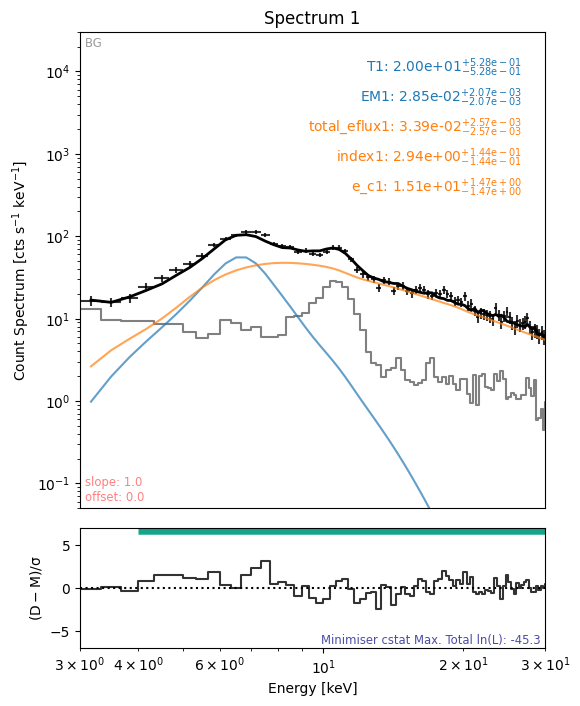

In [12]:
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = fitter.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()

In [13]:
# Try now with the background being subtracted from the data, instead of part of the model fit
fitter2 = Fitter(rhess_spec)

fitter2.model = "(f_vth+thick_fn)"
fitter2.loglikelihood = "cstat"
fitter2.show_params

fitter2.data.loaded_spec_data["spectrum1"].subtract_background = True
# fitter2.data.loaded_spec_data["spectrum1"].data2data_minus_background = True


fitter2.energy_fitting_range = [4,10]
fitter2.params["T1_spectrum1"] = {"Value":10, "Bounds":(7, 20)}
fitter2.params["EM1_spectrum1"] = {"Value":1, "Bounds":(1e-2, 1e2)}
fitter2.params["total_eflux1_spectrum1"] = {"Status":"fix", "Value":0.9, "Bounds":(1e-2, 1e2)}
fitter2.params["index1_spectrum1"] = {"Status":"fix", "Value":6, "Bounds":(2, 12)}
fitter2.params["e_c1_spectrum1"] = {"Status":"fix", "Value":15, "Bounds":(5, 30)}
spec_fit2 = fitter2.fit()

# Then non-thermal fit higher energy
fitter2.energy_fitting_range = [12,33]
fitter2.params["T1_spectrum1"] = "fix"
fitter2.params["EM1_spectrum1"] = "fix"
fitter2.params["total_eflux1_spectrum1"] = "free"
fitter2.params["index1_spectrum1"] = "free"
fitter2.params["e_c1_spectrum1"] = "free"
spec_fit2 = fitter2.fit()

# The do the full range
fitter2.energy_fitting_range = [4,33]
fitter2.params["T1_spectrum1"] = "free"
fitter2.params["EM1_spectrum1"] = "free"
fitter2.params["total_eflux1_spectrum1"] = "free"
fitter2.params["index1_spectrum1"] = "free"
fitter2.params["e_c1_spectrum1"] = "free"
spec_fit2 = fitter2.fit()

In [14]:
print(spec_fit)
print(spec_fit2)

[20.0, 0.028488288874139324, 0.033868110633726634, 2.941902145022161, 15.098201386328743]
[8.936949641744913, 19.994195204642985, 1.3137187959377936, 3.9170568728933723, 11.851655228248319]


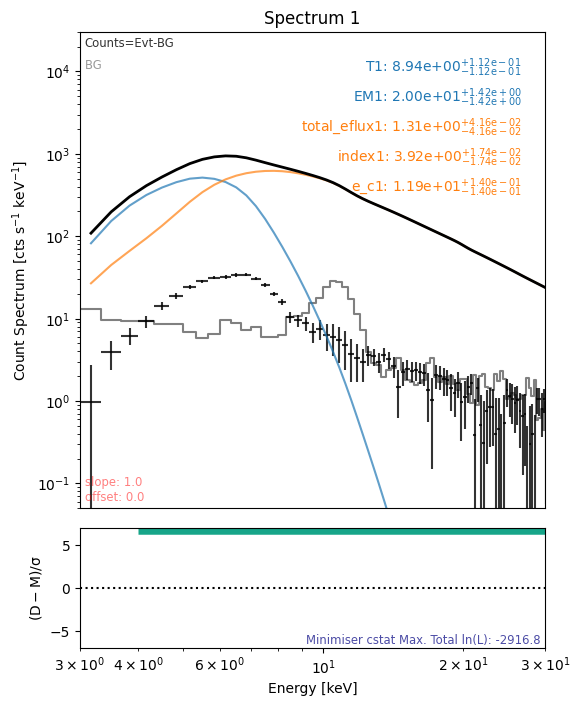

In [15]:
plt.figure(figsize=spec_single_plot_size)
axes, res_axes = fitter2.plot()
for a in axes:
    a.set_xlim(xlims)
    a.set_ylim(ylims)
    a.set_xscale("log")
plt.show()